# Working with Multiple Time Series in TimeDB

This notebook demonstrates how to efficiently work with multiple time series in a single database.

## What you'll learn:
1. **Creating multiple related series** - Setting up series with consistent naming and labels
2. **Batch insertion** - Writing data for multiple series at once
3. **Reading multiple series** - Retrieving and combining data from related series
4. **Filtering by labels** - Using labels to query subsets of series
5. **Wide vs long format** - Understanding different data layouts
6. **Aggregations** - Computing statistics across multiple series

**Key Concepts:**
- **Labels**: Key-value pairs that help organize and filter related series
- **Series collections**: Groups of series selected by name, unit, and labels
- **Wide format**: Each series is a column (good for analysis)
- **Long format**: Each row is one observation (good for database operations)
- **Multi-series operations**: Efficient patterns for working with many series

In [1]:
from timedb import TimeDataClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timezone, timedelta
from dotenv import load_dotenv
load_dotenv()

td = TimeDataClient()
td.delete()
td.create()

Creating database schema...
✓ Schema created successfully


## Part 1: Creating Multiple Related Series

Let's create a wind farm monitoring system with multiple turbines and sensors.
We'll use labels to organize the series by location and sensor type.

In [2]:
# Define wind farm structure
sites = ['NorthFarm', 'SouthFarm']
turbines_per_site = ['T01', 'T02', 'T03']
sensor_types = [
    ('power', 'dimensionless', 'Power output'),
    ('wind_speed', 'dimensionless', 'Wind speed at hub height'),
    ('temperature', 'dimensionless', 'Nacelle temperature'),
]

# Create all series
series_created = []
for site in sites:
    for turbine in turbines_per_site:
        for sensor_name, unit, description in sensor_types:
            series_id = td.create_series(
                name=sensor_name,
                unit=unit,
                labels={
                    'site': site,
                    'turbine': turbine,
                },
                description=f"{description} for {turbine} at {site}",
                data_class='flat'
            )
            series_created.append({
                'site': site,
                'turbine': turbine,
                'sensor': sensor_name,
                'series_id': series_id
            })

print(f"\n✓ Created {len(series_created)} time series")
print(f"  Sites: {sites}")
print(f"  Turbines per site: {turbines_per_site}")
print(f"  Sensors per turbine: {[s[0] for s in sensor_types]}")
print(f"  Total: {len(sites)} sites × {len(turbines_per_site)} turbines × {len(sensor_types)} sensors = {len(series_created)} series")


✓ Created 18 time series
  Sites: ['NorthFarm', 'SouthFarm']
  Turbines per site: ['T01', 'T02', 'T03']
  Sensors per turbine: ['power', 'wind_speed', 'temperature']
  Total: 2 sites × 3 turbines × 3 sensors = 18 series


## Part 2: Batch Data Insertion

Now let's generate and insert 24 hours of data for all sensors.
We'll insert data for each turbine's sensors together.

In [3]:
# Generate time series
base_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
times = [base_time + timedelta(hours=i) for i in range(24)]

# Generate synthetic data for each site/turbine combination
np.random.seed(42)

for site in sites:
    # Site-specific wind pattern (NorthFarm has more wind)
    site_wind_factor = 1.2 if site == 'NorthFarm' else 0.9
    
    for turbine in turbines_per_site:
        # Turbine-specific efficiency
        turbine_efficiency = {'T01': 0.95, 'T02': 0.90, 'T03': 0.92}[turbine]
        
        # Generate wind speed (varies by hour with some randomness)
        wind_speeds = [
            site_wind_factor * (8.0 + 3.0 * np.sin(2 * np.pi * i / 24) + np.random.normal(0, 0.5))
            for i in range(24)
        ]
        wind_speeds = [max(0, round(w, 2)) for w in wind_speeds]  # Non-negative
        
        # Power output (cubic relationship with wind speed, with efficiency)
        # P = 0.5 * ρ * A * v³ * Cp (simplified)
        power_outputs = [
            turbine_efficiency * 0.5 * (w ** 3) / 50  # Scaling factor
            for w in wind_speeds
        ]
        power_outputs = [round(p, 2) for p in power_outputs]
        
        # Temperature (increases with power output + ambient)
        temperatures = [
            20.0 + p * 0.3 + np.random.normal(0, 1.0)
            for p in power_outputs
        ]
        temperatures = [round(t, 2) for t in temperatures]
        
        # Create DataFrame with all sensors for this turbine
        df = pd.DataFrame({
            'valid_time': times,
            'power': power_outputs,
            'wind_speed': wind_speeds,
            'temperature': temperatures,
        })
        
        # Insert using collection that matches this turbine
        result = td.series().where(site=site, turbine=turbine).insert(df)
        print(f"✓ Inserted data for {site} {turbine}: {len(times)} rows × {len(sensor_types)} sensors")

✓ Inserted data for NorthFarm T01: 24 rows × 3 sensors
✓ Inserted data for NorthFarm T02: 24 rows × 3 sensors
✓ Inserted data for NorthFarm T03: 24 rows × 3 sensors
✓ Inserted data for SouthFarm T01: 24 rows × 3 sensors
✓ Inserted data for SouthFarm T02: 24 rows × 3 sensors
✓ Inserted data for SouthFarm T03: 24 rows × 3 sensors


## Part 3: Reading Multiple Series with Filters

Now let's explore different ways to read and filter multiple series.

In [4]:
# Example 1: Read all power data from NorthFarm
df_north_power = td.series('power').where(site='NorthFarm').read()

print("=== NorthFarm Power Output ===")
print(f"Shape: {df_north_power.shape}")
print(f"Columns (turbines): {list(df_north_power.columns)}")
print(f"\nFirst few rows:")
print(df_north_power.head())

# Example 2: Read all sensors for a specific turbine
df_t01_north = td.series().where(site='NorthFarm', turbine='T01').read()

print("\n=== NorthFarm T01 All Sensors ===")
print(f"Shape: {df_t01_north.shape}")
print(f"Columns (sensors): {list(df_t01_north.columns)}")
print(f"\nFirst few rows:")
print(df_t01_north.head())

=== NorthFarm Power Output ===
Shape: (24, 3)
Columns (turbines): ['power', 'power', 'power']

First few rows:
name                       power  power  power
valid_time                                    
2025-01-01 00:00:00+00:00   8.61   9.22    8.5
2025-01-01 01:00:00+00:00  11.24  10.84   7.64
2025-01-01 02:00:00+00:00  13.63  15.57  14.01
2025-01-01 03:00:00+00:00   15.9  21.16   15.2
2025-01-01 04:00:00+00:00  15.39  18.91  16.79

=== NorthFarm T01 All Sensors ===
Shape: (24, 3)
Columns (sensors): ['temperature', 'power', 'wind_speed']

First few rows:
name                       temperature  power  wind_speed
valid_time                                               
2025-01-01 00:00:00+00:00        22.22   9.22         9.9
2025-01-01 01:00:00+00:00        23.36  10.84       10.45
2025-01-01 02:00:00+00:00        23.52  15.57       11.79
2025-01-01 03:00:00+00:00        26.72  21.16       13.06
2025-01-01 04:00:00+00:00        25.07  18.91       12.58


## Part 4: Cross-Site Comparison

Let's compare power output between the two sites.

In [5]:
# Read power data from both sites
df_south_power = td.series('power').where(site='SouthFarm').read()

# Combine for comparison
print("=== Power Output Comparison ===")
print(f"\nNorthFarm turbines: {list(df_north_power.columns)}")
print(f"SouthFarm turbines: {list(df_south_power.columns)}")

# Calculate site totals
north_total = df_north_power.sum(axis=1)
south_total = df_south_power.sum(axis=1)

print(f"\nNorthFarm total production: {north_total.sum():.2f} MWh")
print(f"SouthFarm total production: {south_total.sum():.2f} MWh")
print(f"Difference: {(north_total.sum() - south_total.sum()):.2f} MWh ({(north_total.sum() / south_total.sum() - 1) * 100:.1f}%)")

=== Power Output Comparison ===

NorthFarm turbines: ['power', 'power', 'power']
SouthFarm turbines: ['power', 'power', 'power']

NorthFarm total production: 721.13 dimensionless MWh
SouthFarm total production: 306.29 dimensionless MWh
Difference: 414.84 dimensionless MWh (135.4 dimensionless%)


## Part 5: Visualizing Multiple Series

Let's create visualizations to understand the data across multiple series.

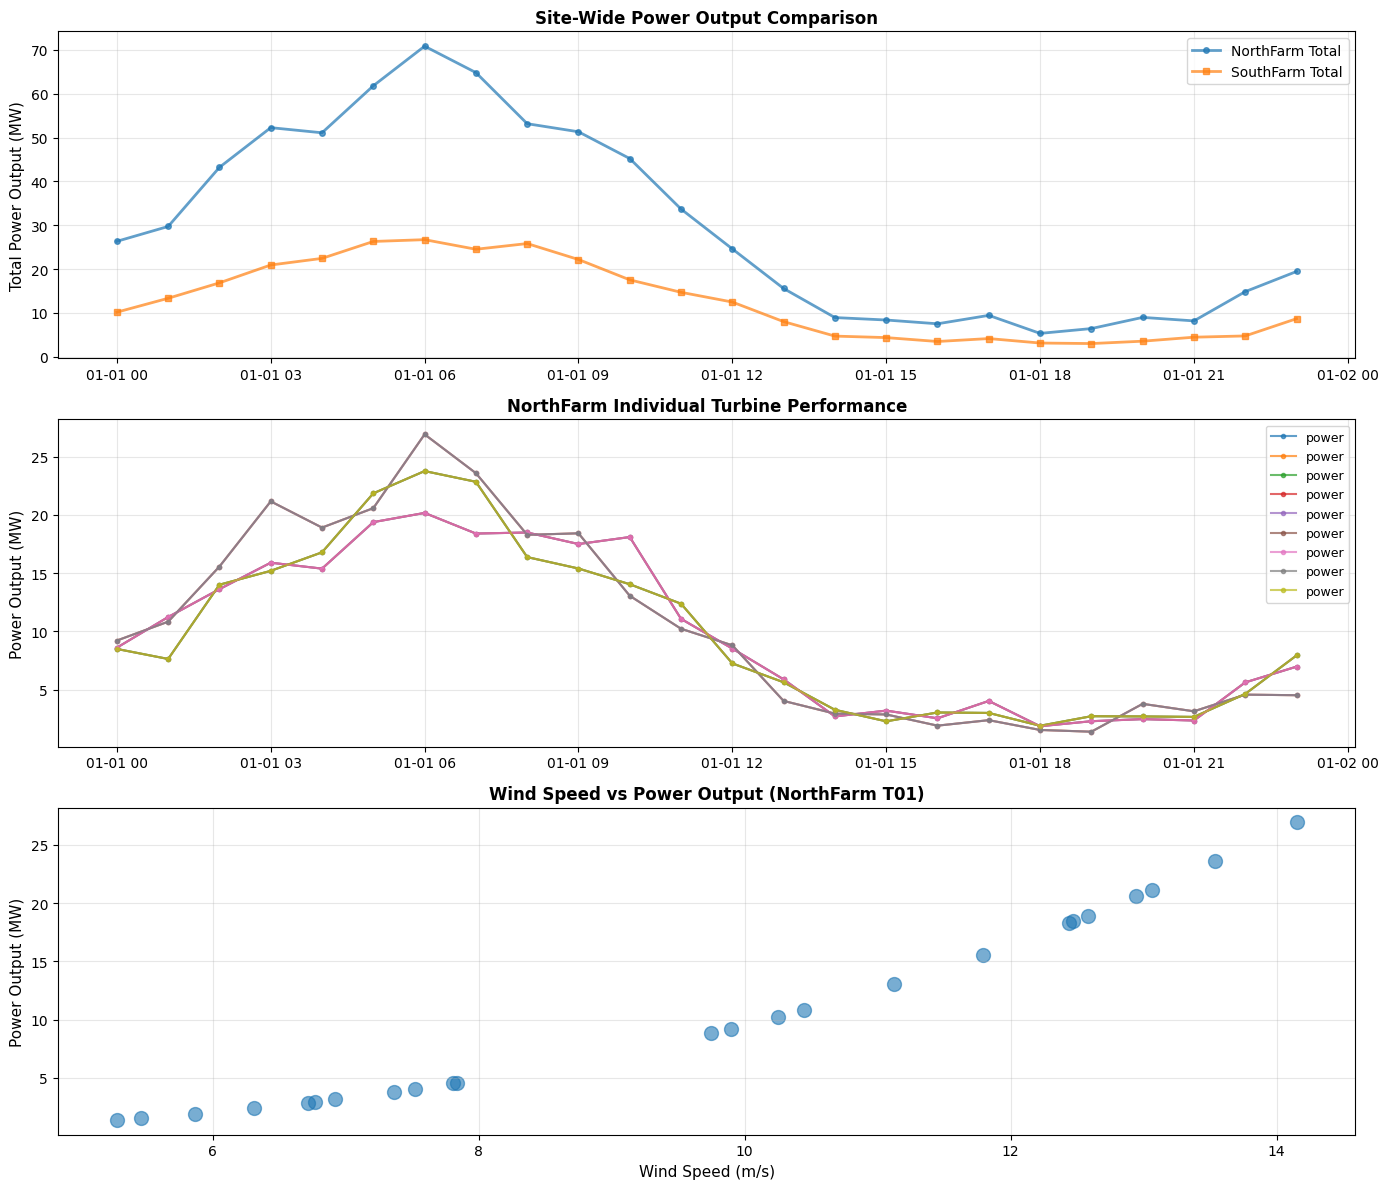

✓ Plots generated successfully!


In [6]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Site-wide power comparison
ax1 = axes[0]
ax1.plot(north_total.index, north_total.values, label='NorthFarm Total', 
         linewidth=2, marker='o', markersize=4, alpha=0.7)
ax1.plot(south_total.index, south_total.values, label='SouthFarm Total', 
         linewidth=2, marker='s', markersize=4, alpha=0.7)
ax1.set_ylabel('Total Power Output (MW)', fontsize=11)
ax1.set_title('Site-Wide Power Output Comparison', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Individual turbine comparison at NorthFarm
ax2 = axes[1]
for col in df_north_power.columns:
    ax2.plot(df_north_power.index, df_north_power[col].values, 
             label=col, linewidth=1.5, marker='o', markersize=3, alpha=0.7)
ax2.set_ylabel('Power Output (MW)', fontsize=11)
ax2.set_title('NorthFarm Individual Turbine Performance', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Wind speed vs Power (scatter for one turbine)
ax3 = axes[2]
wind_data = df_t01_north['wind_speed'].values
power_data = df_t01_north['power'].values
ax3.scatter(wind_data, power_data, alpha=0.6, s=100)
ax3.set_xlabel('Wind Speed (m/s)', fontsize=11)
ax3.set_ylabel('Power Output (MW)', fontsize=11)
ax3.set_title('Wind Speed vs Power Output (NorthFarm T01)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Plots generated successfully!")

## Part 6: Aggregations Across Multiple Series

Let's compute various statistics across our time series.

In [10]:
# Calculate statistics for each turbine's power output
print("=== Power Output Statistics ===")
print("\nNorthFarm:")
print(df_north_power.describe())

print("\nSouthFarm:")
print(df_south_power.describe())

# Find peak production times
print("\n=== Peak Production Times ===")
north_peak_time = north_total.idxmax()
north_peak_value = north_total.max()
south_peak_time = south_total.idxmax()
south_peak_value = south_total.max()

print(f"NorthFarm peak: {north_peak_value:.2f} MW at {north_peak_time}")
print(f"SouthFarm peak: {south_peak_value:.2f} MW at {south_peak_time}")

# Calculate capacity factor for each turbine (assuming 5 MW rated capacity)
rated_capacity = 5.0  # MW
print("\n=== Capacity Factors (%) ===")
print("\nNorthFarm:")
for col in df_north_power.columns:
    col_mean_value = df_north_power[col].mean()
    cf = (col_mean_value / rated_capacity) * 100
    # Extract scalar value from Series if needed, then convert to float
    if isinstance(cf, pd.Series):
        cf = cf.iloc[0]
    cf_value = float(cf.magnitude) if hasattr(cf, 'magnitude') else float(cf)
    print(f"  {col}: {cf_value:.1f}%")

print("\nSouthFarm:")
for col in df_south_power.columns:
    col_mean_value = df_south_power[col].mean()
    cf = (col_mean_value / rated_capacity) * 100
    # Extract scalar value from Series if needed, then convert to float
    if isinstance(cf, pd.Series):
        cf = cf.iloc[0]
    cf_value = float(cf.magnitude) if hasattr(cf, 'magnitude') else float(cf)
    print(f"  {col}: {cf_value:.1f}%")

=== Power Output Statistics ===

NorthFarm:
name      power     power     power
count      24.0      24.0      24.0
mean   9.851667    10.365  9.830417
std    6.642779  8.116255  7.130279
min        1.87       1.4      1.91
25%       3.085       3.1      3.04
50%        8.57     9.015      7.79
75%        16.3   18.3225     15.25
max       20.17     26.91     23.76

SouthFarm:
name      power     power     power
count      24.0      24.0      24.0
mean   4.169167      4.18  4.412917
std     3.06015  2.783718  3.014656
min        0.72      0.97      0.71
25%      1.2525      1.65     1.525
50%       3.785      3.19     3.955
75%      6.8775      6.95    6.5125
max       10.14      8.81      9.53

=== Peak Production Times ===
NorthFarm peak: 70.84 dimensionless MW at 2025-01-01 06:00:00+00:00
SouthFarm peak: 26.71 dimensionless MW at 2025-01-01 06:00:00+00:00

=== Capacity Factors (%) ===

NorthFarm:
  power: 197.0%
  power: 197.0%
  power: 197.0%

SouthFarm:
  power: 83.4%
  power: 83.

## Part 7: Working with Series Collections

Let's explore the series collection API for discovering and filtering series.

In [13]:
# Count series by different criteria
print("=== Series Collection Exploration ===")
print(f"\nTotal series in database: {td.series().count()}")
print(f"Power series: {td.series('power').count()}")
print(f"NorthFarm series: {td.series().where(site='NorthFarm').count()}")
print(f"T01 turbines across all sites: {td.series().where(turbine='T01').count()}")

# Available labels: 'site' (NorthFarm, SouthFarm) and 'turbine' (T01, T02, T03)
print("\n=== Available Labels ===")
print("  site: ['NorthFarm', 'SouthFarm']")
print("  turbine: ['T01', 'T02', 'T03']")

# Example: Narrow down progressively
print("\n=== Progressive Filtering ===")
collection = td.series()
print(f"Start with all series: {collection.count()}")

collection = collection.where(site='NorthFarm')
print(f"Filter by site='NorthFarm': {collection.count()}")

collection = collection.where(turbine='T01')
print(f"Filter by turbine='T01': {collection.count()}")

collection = td.series('power').where(site='NorthFarm', turbine='T01')
print(f"Filter by name='power': {collection.count()}")

# Verify we can read it
if collection.count() == 1:
    df_single = collection.read()
    print(f"\n✓ Successfully read the single series")
    print(f"  Shape: {df_single.shape}")
    print(f"  Columns: {list(df_single.columns)}")

=== Series Collection Exploration ===

Total series in database: 18
Power series: 6
NorthFarm series: 9
T01 turbines across all sites: 6

=== Available Labels ===
  site: ['NorthFarm', 'SouthFarm']
  turbine: ['T01', 'T02', 'T03']

=== Progressive Filtering ===
Start with all series: 18
Filter by site='NorthFarm': 9
Filter by turbine='T01': 3
Filter by name='power': 1

✓ Successfully read the single series
  Shape: (24, 1)
  Columns: ['power']


## Part 8: Correlation Analysis

Let's analyze correlations between different sensors and turbines.

=== Sensor Correlation Analysis (NorthFarm T01) ===

Correlation matrix:
name         temperature     power  wind_speed
name                                          
temperature     1.000000  0.947078    0.915348
power           0.947078  1.000000    0.978875
wind_speed      0.915348  0.978875    1.000000

=== Cross-Turbine Correlation (NorthFarm Power) ===
name      power     power     power
name                               
power  1.000000  0.957280  0.962299
power  0.957280  1.000000  0.971281
power  0.962299  0.971281  1.000000

Interpretation: High correlation suggests turbines experience similar wind conditions


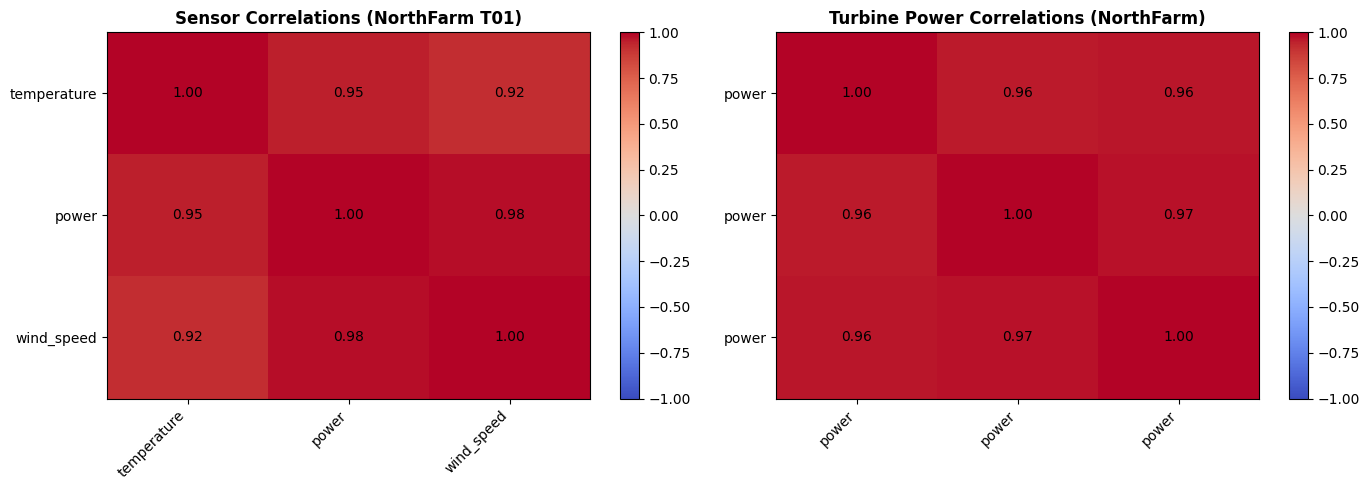


✓ Correlation analysis complete!


In [14]:
# Analyze correlation between wind speed and power for T01 at NorthFarm
print("=== Sensor Correlation Analysis (NorthFarm T01) ===")
correlation_matrix = df_t01_north.corr()
print("\nCorrelation matrix:")
print(correlation_matrix)

# Cross-turbine correlation (do turbines at same site correlate?)
print("\n=== Cross-Turbine Correlation (NorthFarm Power) ===")
turbine_correlation = df_north_power.corr()
print(turbine_correlation)
print("\nInterpretation: High correlation suggests turbines experience similar wind conditions")

# Visualize correlations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for sensor correlations
ax1 = axes[0]
im1 = ax1.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax1.set_xticks(range(len(correlation_matrix.columns)))
ax1.set_yticks(range(len(correlation_matrix.columns)))
ax1.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
ax1.set_yticklabels(correlation_matrix.columns)
ax1.set_title('Sensor Correlations (NorthFarm T01)', fontsize=12, fontweight='bold')
plt.colorbar(im1, ax=ax1)

# Add correlation values as text
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax1.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                       ha='center', va='center', color='black', fontsize=10)

# Heatmap for turbine correlations
ax2 = axes[1]
im2 = ax2.imshow(turbine_correlation, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax2.set_xticks(range(len(turbine_correlation.columns)))
ax2.set_yticks(range(len(turbine_correlation.columns)))
ax2.set_xticklabels(turbine_correlation.columns, rotation=45, ha='right')
ax2.set_yticklabels(turbine_correlation.columns)
ax2.set_title('Turbine Power Correlations (NorthFarm)', fontsize=12, fontweight='bold')
plt.colorbar(im2, ax=ax2)

# Add correlation values as text
for i in range(len(turbine_correlation.columns)):
    for j in range(len(turbine_correlation.columns)):
        text = ax2.text(j, i, f'{turbine_correlation.iloc[i, j]:.2f}',
                       ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Correlation analysis complete!")

## Summary

This notebook demonstrated working with multiple time series in TimeDB:

### 1. Series Organization
- Created 18 time series (2 sites × 3 turbines × 3 sensors)
- Used **labels** (`site`, `turbine`) to organize related series
- Each series has a descriptive name, unit, and metadata

### 2. Batch Operations
- Inserted data for multiple sensors per turbine in single operations
- Used pint-pandas for unit-aware data insertion
- Efficient batch insertion reduces database operations

### 3. Flexible Querying
- Used `.where()` to filter series by labels
- Combined name, unit, and label filters
- Progressive filtering: start broad, narrow down

### 4. Data Analysis Patterns
- **Wide format**: Each series as a column (good for analysis)
- **Aggregations**: Site totals, statistics, capacity factors
- **Correlations**: Within-turbine (sensors) and cross-turbine (wind conditions)

### 5. Series Discovery
- Use `.count()` to see how many series match filters
- Use `.list_labels()` to discover available label values
- Verify filters before reading large datasets

### Best Practices for Multiple Series
1. **Consistent naming**: Use same sensor names across locations
2. **Meaningful labels**: Use labels to encode hierarchy (site → turbine → sensor)
3. **Batch insertion**: Insert related data together when possible
4. **Progressive filtering**: Use `.count()` to verify filters before reading
5. **Units**: Always specify units for physical quantities

### Next Steps
- Check out `nb_06_advanced_querying.ipynb` for time range queries and complex filters
- See `nb_04_timeseries_changes.ipynb` for updating multiple series